# DEEP LEARNING MODEL

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [23]:
# Activities are the class labels
# It is a 6 class classification

ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING'
}


# function to print confusion matrix

def confusion_matrix(y_true, y_pred):
    y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(y_true, axis=1)])
    y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(y_pred, axis=1)])
    
    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Pred'])

## DATA

In [3]:
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals from Accelerometer and Gyroscope in x,y,z directions

SIGNALS = [
    'body_acc_x',
    'body_acc_y',
    'body_acc_z',
    'body_gyro_x',
    'body_gyro_y',
    'body_gyro_z',
    'total_acc_x',
    'total_acc_y',
    'total_acc_z'
]

In [5]:
# function to read data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# function to load the data
def load_signals(subset):
    signals_data = []
    
    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
        _read_csv(filename).as_matrix()
        )
        
    # Transpose is used to change the dimensionality of the output, aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    
    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    x_train, x_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    
    return x_train, x_test, y_train, y_test

In [8]:
np.random.seed(42)

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout


# Intialiazing parameters
epochs = 30
batch_size = 16
n_hidden = 32

Using TensorFlow backend.


In [9]:
# function to count number of classes
def count_classes(y):
    return len(set([tuple(category) for category in y]))

In [11]:
# loading thr train and test data
x_train, x_test, y_train, y_test = load_data()

In [14]:
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = count_classes(y_train)

print(timesteps)
print(input_dim)
print(n_classes)

128
9
6


## LSTM Architecture

In [45]:
# intializing the sequential model
model = Sequential()

model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(16))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [46]:
# compiling the model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop', 
    metrics = ['accuracy']
    )

In [47]:
# training the model
model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test,y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.4504 - acc: 0.3968 - val_loss: 1.2384 - val_acc: 0.5022
Epoch 2/30
7352/7352 [==============================] - 67s 9ms/step - loss: 1.0545 - acc: 0.5766 - val_loss: 0.9187 - val_acc: 0.5792
Epoch 3/30
7352/7352 [==============================] - 64s 9ms/step - loss: 0.8684 - acc: 0.6076 - val_loss: 0.8170 - val_acc: 0.6132
Epoch 4/30
7352/7352 [==============================] - 60s 8ms/step - loss: 0.8009 - acc: 0.6182 - val_loss: 0.7857 - val_acc: 0.6291
Epoch 5/30
7352/7352 [==============================] - 63s 9ms/step - loss: 0.7563 - acc: 0.6307 - val_loss: 0.7803 - val_acc: 0.6203
Epoch 6/30
7352/7352 [==============================] - 62s 8ms/step - loss: 0.7566 - acc: 0.6484 - val_loss: 0.8316 - val_acc: 0.6132
Epoch 7/30
7352/7352 [==============================] - 62s 8ms/step - loss: 0.6881 - acc: 0.6770 - val_loss: 0.7592 - val_acc: 0.6111
Epoch 8

In [48]:
# confusion matrix
print(confusion_matrix(y_test, model.predict(x_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 516        0        13        1                   0   
SITTING                  3      415        62        9                   0   
STANDING                 0      106       426        0                   0   
WALKING                  0        0         0      454                  18   
WALKING_DOWNSTAIRS       0        0         0        0                 409   
WALKING_UPSTAIRS         0        0         0       20                  29   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             7  
SITTING                            2  
STANDING                           0  
WALKING                           24  
WALKING_DOWNSTAIRS                11  
WALKING_UPSTAIRS                 422  


In [49]:
score = model.evaluate(x_test, y_test)

2947/2947 [==============================] - 2s 678us/step


In [50]:
score

[0.5662827165484365, 0.8965049202578894]

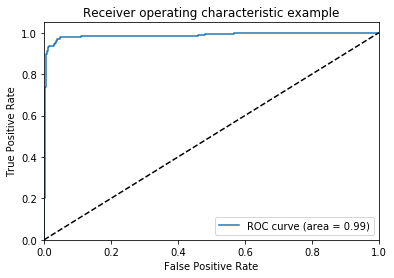

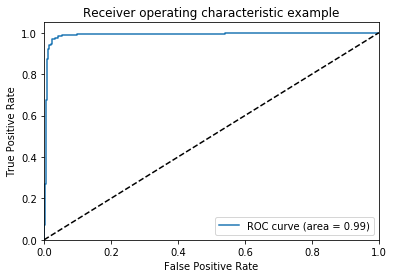

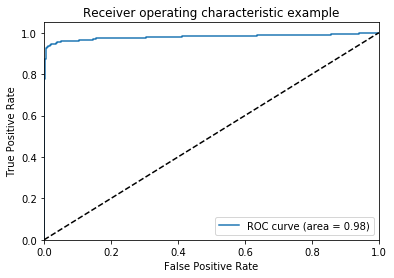

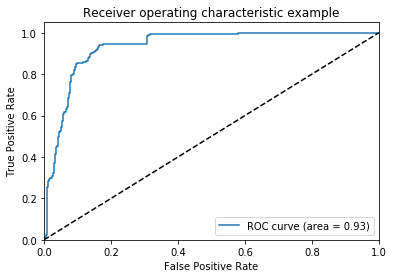

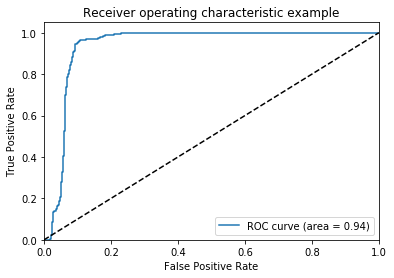

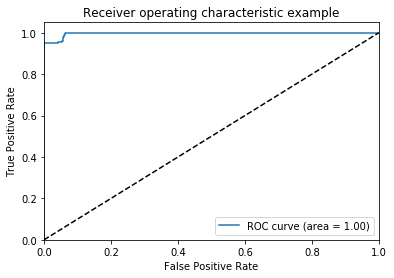

In [37]:
# ROC curve for each class

from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()